In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.layers import GRU, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

Загрузка датасета

In [3]:
# импортируем модуль os
import os

# из библиотеки google.colab импортируем класс files
from google.colab import files

# создаем объект этого класса, применяем метод .upload()
uploaded = files.upload()

dataset = pd.read_csv('/content/price_prediction_dataset.csv')
dataset.info()

Saving price_prediction_dataset.csv to price_prediction_dataset.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             4383 non-null   object
 1   product          4383 non-null   object
 2   sales            4383 non-null   int64 
 3   price            4383 non-null   int64 
 4   discount         4383 non-null   int64 
 5   advertising      4383 non-null   int64 
 6   stock_level      4383 non-null   int64 
 7   month            4383 non-null   int64 
 8   day_of_week      4383 non-null   int64 
 9   is_weekend       4383 non-null   int64 
 10  day_of_year      4383 non-null   int64 
 11  quarter          4383 non-null   int64 
 12  product_encoded  4383 non-null   int64 
dtypes: int64(11), object(2)
memory usage: 445.3+ KB


Подготовка датасета

In [4]:
def prepare_data():
    data = dataset
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['product', 'date'])


    le = LabelEncoder()
    data['product_encoded'] = le.fit_transform(data['product'])


    feature_cols = [
        'product_encoded', 'sales', 'discount', 'advertising',
        'stock_level', 'month', 'day_of_week', 'is_weekend',
        'day_of_year', 'quarter'
    ]

    target_col = 'price'

    return data, feature_cols, target_col, le

In [5]:
def create_sequences(data, feature_cols, target_col, sequence_length=15):
    sequences = []
    labels = []
    original_labels = []

    data = data.sort_values(['product_encoded', 'date'])
    unique_products = data['product_encoded'].unique()

    for product in unique_products:
        product_data = data[data['product_encoded'] == product].sort_values('date')

        if len(product_data) < sequence_length + 1:
            continue

        # Зависимости от
        X_product = product_data[feature_cols].values
        # Цена
        y_product = product_data[target_col].values

        # Нормализация
        X_min, X_max = X_product.min(axis=0), X_product.max(axis=0)
        y_min, y_max = y_product.min(), y_product.max()

        X_normalized = (X_product - X_min) / (X_max - X_min + 1e-8)
        y_normalized = (y_product - y_min) / (y_max - y_min + 1e-8)

        for i in range(sequence_length, len(product_data)):
            seq_features = X_normalized[i - sequence_length:i]
            target_value = y_normalized[i]
            original_value = y_product[i]

            sequences.append(seq_features)
            labels.append(target_value)
            original_labels.append(original_value)

    return np.array(sequences), np.array(labels), np.array(original_labels)

In [6]:
data, feature_cols, target_col, label_encoder = prepare_data()

data = data.sort_values(['product', 'date'])
split_date = data['date'].quantile(0.8)
train_data = data[data['date'] <= split_date]
test_data = data[data['date'] > split_date]

SEQ_LENGTH = 18
train_seq, train_label, train_original = create_sequences(train_data, feature_cols, target_col, SEQ_LENGTH)
test_seq, test_label, test_original = create_sequences(test_data, feature_cols, target_col, SEQ_LENGTH)

Модель GRU

In [7]:
model = Sequential([
    GRU(48, activation='tanh', return_sequences=True, input_shape=(SEQ_LENGTH, len(feature_cols))),
    Dropout(0.8),
    GRU(8, activation='tanh', return_sequences=True),
    Dropout(0.5),
    GRU(16, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(12, activation='relu'),
    Dense(12, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
len(feature_cols)

10

In [8]:
optimizer = Adam(learning_rate=0.0005)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    min_delta=0.001
)

In [9]:
model.compile(
    loss='mse',
    optimizer=optimizer,
    metrics=['mae']
)

In [10]:
history = model.fit(
    train_seq, train_label,
    epochs=40,
    batch_size=16,
    validation_data=(test_seq, test_label),
    callbacks=[early_stop],
    verbose=1,
    shuffle=False
)

Epoch 1/40
216/216 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0340 - mae: 0.1494 - val_loss: 0.0380 - val_mae: 0.1575
Epoch 2/40
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0303 - mae: 0.1413 - val_loss: 0.0380 - val_mae: 0.1560
Epoch 3/40
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0289 - mae: 0.1382 - val_loss: 0.0382 - val_mae: 0.1556
Epoch 4/40
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0279 - mae: 0.1368 - val_loss: 0.0381 - val_mae: 0.1546
Epoch 5/40
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0274 - mae: 0.1348 - val_loss: 0.0374 - val_mae: 0.1533
Epoch 6/40
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0269 - mae: 0.1342 - val_loss: 0.0371 - val_mae: 0.1524
Epoch 7/40
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0269 - mae: 0.1349 - val_loss: 0.0367 - val_mae: 0.1517
Epoch 8/40
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0269 - mae: 0.1340 - val_loss: 0.0369 - val_mae: 0.1515
Epoch 9/40
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 26m

In [11]:
test_pred_normalized = model.predict(test_seq).flatten()

# Маштабируем цены
test_pred_original = test_pred_normalized * (test_original.max() - test_original.min()) + test_original.min()

min_len = min(len(test_pred_original), len(test_original))
test_pred_original = test_pred_original[:min_len]
test_original = test_original[:min_len]

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [12]:
i = 0
with open("/content/export.txt", "w") as txt_file:
    for i in range(0, len(test_pred_original)):
        txt_file.write(str(test_pred_original[i]) + "\n")

In [13]:
len(test_original)

822

Визуализация

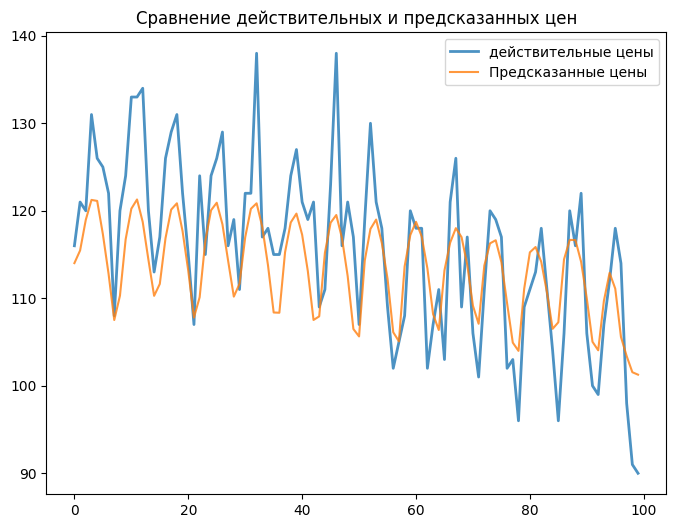

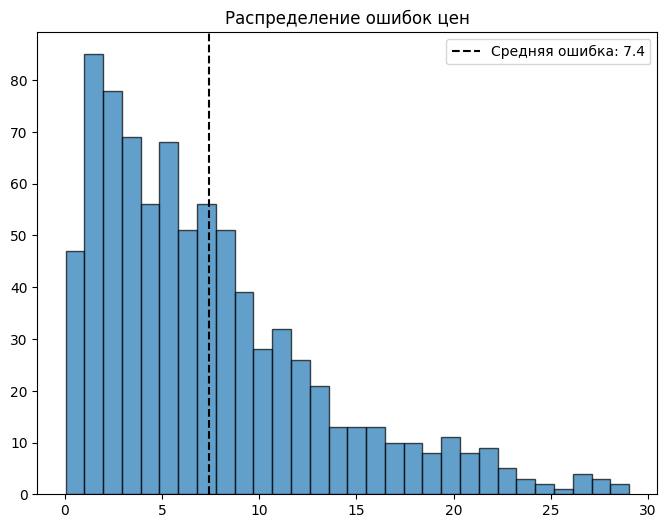

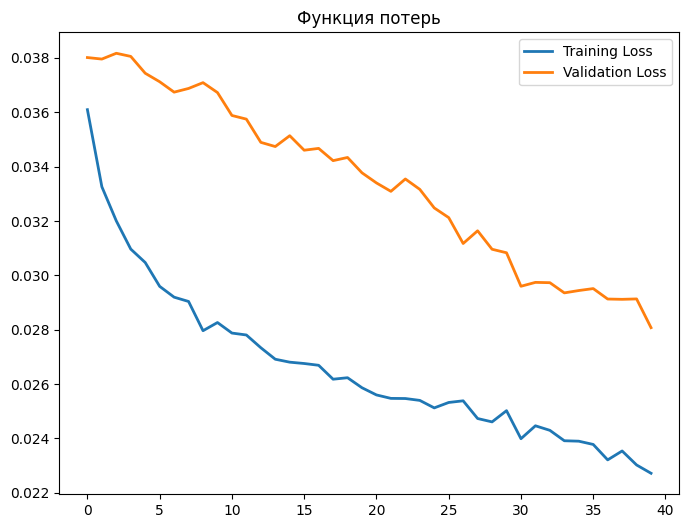

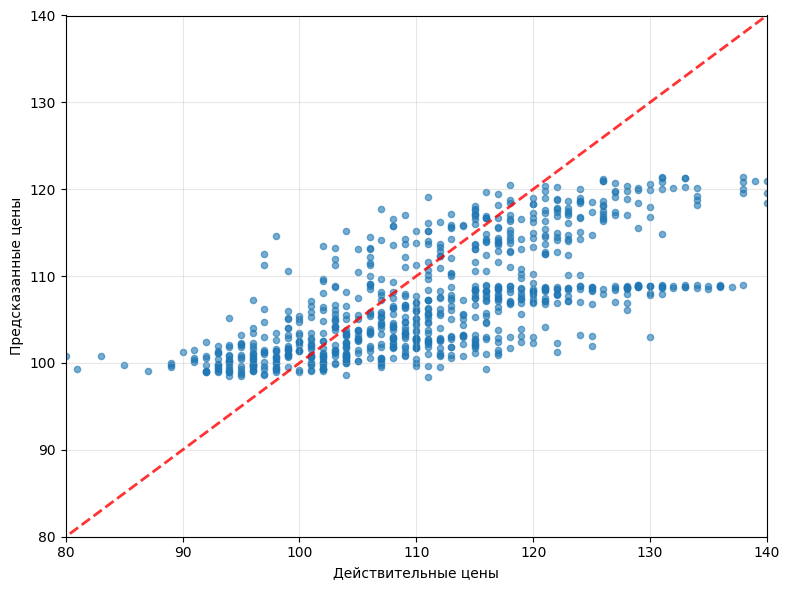

In [14]:
# 1. Сравнение цен
plt.figure(figsize=(8, 6))
plt.plot(test_original[:100], label='действительные цены', linewidth=2, alpha=0.8)
plt.plot(test_pred_original[:100], label='Предсказанные цены', linewidth=1.5, alpha=0.8)
plt.title('Сравнение действительных и предсказанных цен')
plt.legend()

# 2. Ошибки цен
plt.figure(figsize=(8, 6))
errors = np.abs(test_original - test_pred_original)
plt.hist(errors, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(errors.mean(), color='black', linestyle='--', label=f'Средняя ошибка: {errors.mean():.1f}')
plt.title('Распределение ошибок цен')
plt.legend()

# 3. Обучение
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Функция потерь')
plt.legend()

#последний график сравнения всех предсказаний
plt.figure(figsize=(8, 6))
plt.scatter(test_original, test_pred_original, alpha=0.6, s=20)
plt.plot([0, 140], [0, 140], 'r--', alpha=0.8, linewidth=2)

plt.xlim(80, 140)
plt.ylim(80, 140)

plt.xlabel('Действительные цены')
plt.ylabel('Предсказанные цены')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()